In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
import sklearn.preprocessing
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from pydataset import data

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

Regression Modeling Exercises

Select a dataset with a continuous target variable.

Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [22]:
df = data('swiss')


In [23]:
data('swiss', show_doc=True)

swiss

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Swiss Fertility and Socioeconomic Indicators (1888) Data

### Description

Standardized fertility measure and socio-economic indicators for each of 47
French-speaking provinces of Switzerland at about 1888.

### Usage

    data(swiss)

### Format

A data frame with 47 observations on 6 variables, each of which is in percent,
i.e., in [0,100].

[,1] Fertility Ig, "common standardized fertility measure" [,2] Agriculture
[,3] Examination nation [,4] Education [,5] Catholic [,6] Infant.Mortality
live births who live less than 1 year.

All variables but 'Fert' give proportions of the population.

### Source

Project "16P5", pages 549-551 in

Mosteller, F. and Tukey, J. W. (1977) “Data Analysis and Regression: A Second
Course in Statistics”. Addison-Wesley, Reading Mass.

indicating their source as "Data used by permission of Franice van de Walle.
Office of Population Research, Princeton Univer

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [25]:
df['Infant_Mortality'] = df['Infant.Mortality']

In [27]:
df.drop('Infant.Mortality', inplace=True, axis=1)

In [28]:
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant_Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 576x432 with 0 Axes>

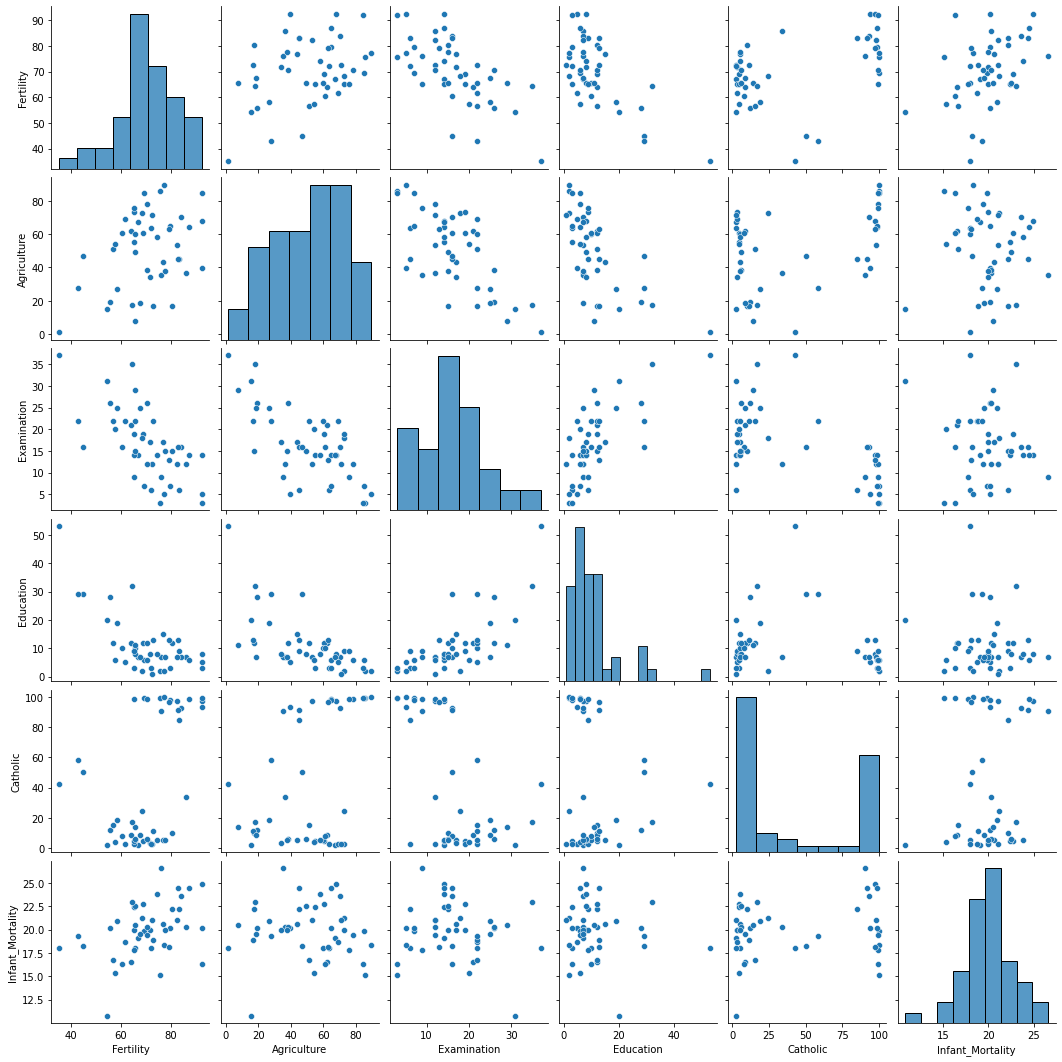

In [29]:
#Visualize
plt.figure(figsize=(8,6))
sns.pairplot(df)
plt.show

In [30]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [31]:
object_cols = get_object_cols(df)

In [32]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [33]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'Agriculture')

In [34]:
def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols

In [35]:
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [36]:
def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [37]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)


In [38]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k=k)
    
    # find the top 8 X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [39]:
select_kbest(X_train_scaled,'Agriculture', 4 )

['Examination', 'Education', 'Catholic', 'Infant_Mortality']

In [40]:
def rfe(x, y, k):
    
    lm = LinearRegression()
    
    rfe = RFE(lm, k)
    
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
    
    mask = rfe.support_
    
    rfe_features = X_train_scaled.loc[:,mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    
    return  rfe_features

In [41]:
#RFE
rfe(X_train_scaled, 'Agriculture', 4)

4 selected features


['Fertility', 'Examination', 'Education', 'Infant_Mortality']

In [42]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict IM_pred_mean
Agriculture_pred_mean = y_train.Agriculture.mean()
y_train['Agriculture_pred_mean'] = Agriculture_pred_mean
y_validate['Agriculture_pred_mean'] = Agriculture_pred_mean

# 2. compute IM_pred_median
Agriculture_pred_median = y_train.Agriculture.median()
y_train['Agriculture_pred_median'] = Agriculture_pred_median
y_validate['Agriculture_pred_median'] = Agriculture_pred_median


# 3. RMSE of IM_pred_mean
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.Agriculture, y_validate.Agriculture_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of IM_pred_median
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_median) ** .5
rmse_validate = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  21.42 
Validate/Out-of-Sample:  21.51
RMSE using Median
Train/In-Sample:  22.14 
Validate/Out-of-Sample:  22.14


In [43]:
y_train.head()

,Agriculture,Agriculture_pred_mean,Agriculture_pred_median
Rolle,60.8,55.196,60.8
Lavaux,73.0,55.196,60.8
Nyone,50.9,55.196,60.8
Conthey,85.9,55.196,60.8
Yverdon,49.5,55.196,60.8


In [44]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Rolle to Avenches
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Agriculture              25 non-null     float64
 1   Agriculture_pred_mean    25 non-null     float64
 2   Agriculture_pred_median  25 non-null     float64
dtypes: float64(3)
memory usage: 1.4+ KB


In [45]:
y_train.shape

(25, 3)

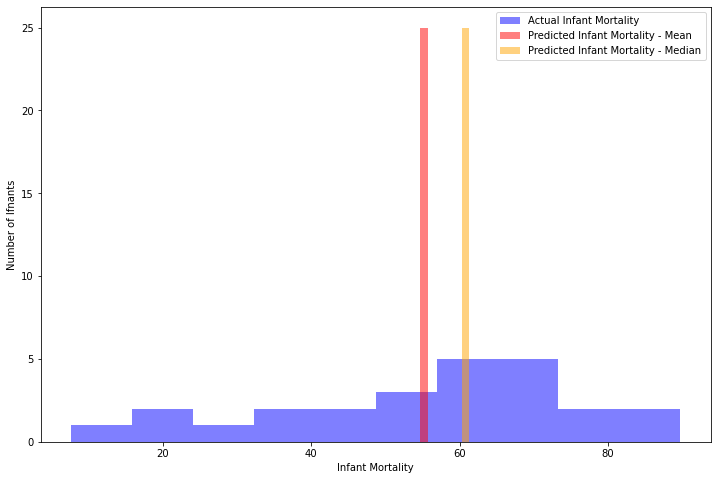

In [46]:
# plot to visualize actual vs predicted.
plt.figure(figsize=(12,8))
plt.hist(y_train.Agriculture, color='blue', alpha=.5, label="Actual Infant Mortality")
plt.hist(y_train.Agriculture_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Infant Mortality - Mean")
plt.hist(y_train.Agriculture_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Infant Mortality - Median")
plt.xlabel("Infant Mortality")
plt.ylabel("Number of Ifnants")
plt.legend()
plt.show()


In [48]:
# create the model object

# 
lm = LinearRegression(normalize=True)

#fit
# 
lm.fit(X_train, y_train.Agriculture)

# predict 

# 
y_train['Agriculture_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_lm) ** (1/2)

# predict validate
y_validate['Agriculture_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Agriculture, y_validate.Agriculture_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  12.796946180526662 
Validation/Out-of-Sample:  18.01903031178874


In [49]:
y_train.head()

,Agriculture,Agriculture_pred_mean,Agriculture_pred_median,Agriculture_pred_lm
Rolle,60.8,55.196,60.8,54.615958
Lavaux,73.0,55.196,60.8,51.212834
Nyone,50.9,55.196,60.8,49.397155
Conthey,85.9,55.196,60.8,80.735423
Yverdon,49.5,55.196,60.8,64.562675


In [50]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.Agriculture)

# predict train
y_train['Agriculture_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_lm) ** (1/2)

# predict validate
y_validate['Agriculture_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Agriculture, y_validate.Agriculture_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  12.796946180526662 
Validation/Out-of-Sample:  18.01903031178874


In [51]:
from sklearn.linear_model import TweedieRegressor

In [52]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.Agriculture)

# predict train
y_train['Agriculture_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_glm) ** (1/2)

# predict validate
y_validate['Agriculture_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  13.189180213108553 
Validation/Out-of-Sample:  13.189180213108553


In [53]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [54]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train, y_train.Agriculture)

# predict train
y_train['Agriculture_pred_lm2'] = lm2.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Agriculture, y_train.Agriculture_pred_lm2) ** (1/2)

# predict validate
y_validate['Agriculture_pred_lm2'] = lm2.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Agriculture, y_validate.Agriculture_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  12.796946180526662 
Validation/Out-of-Sample:  324.68545337716137


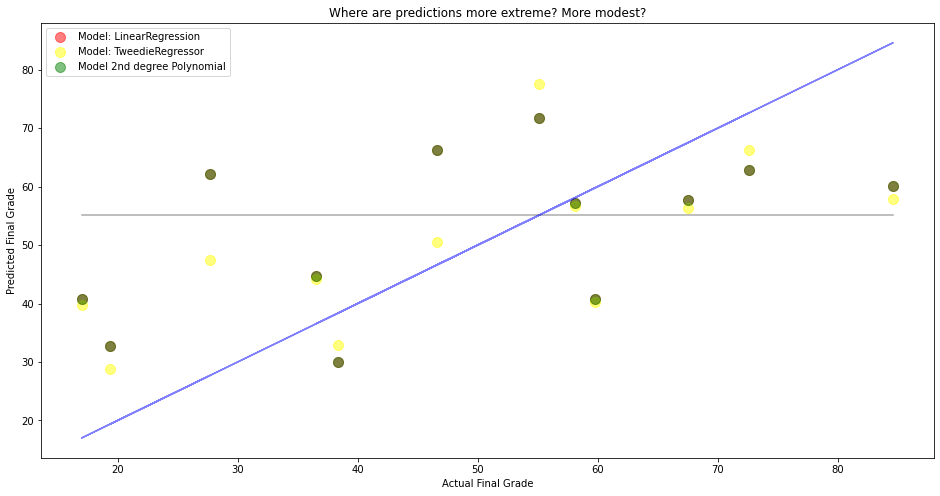

In [55]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.Agriculture, y_validate.Agriculture_pred_mean, alpha=.5, color="gray", label='_nolegend_')
#plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.Agriculture, y_validate.Agriculture, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

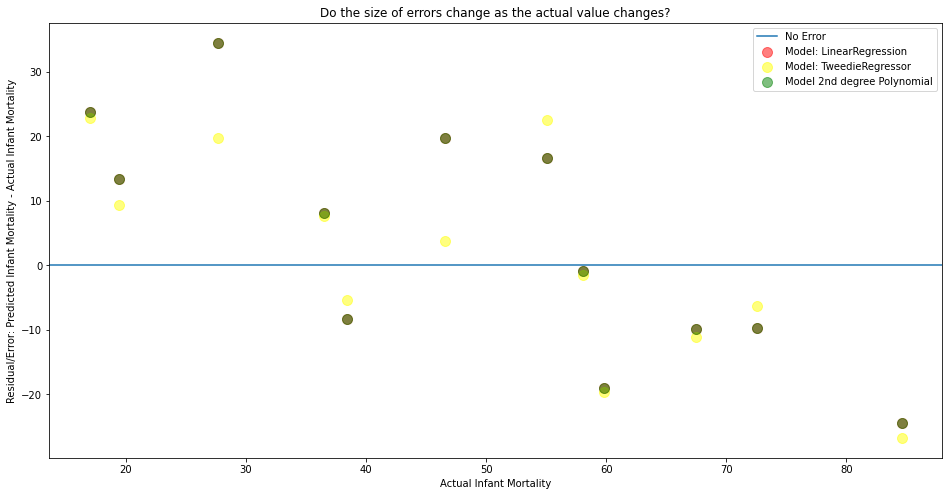

In [56]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_lm - y_validate.Agriculture , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_glm - y_validate.Agriculture, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Agriculture, y_validate.Agriculture_pred_lm2 - y_validate.Agriculture, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Residual/Error: Predicted Infant Mortality - Actual Infant Mortality")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

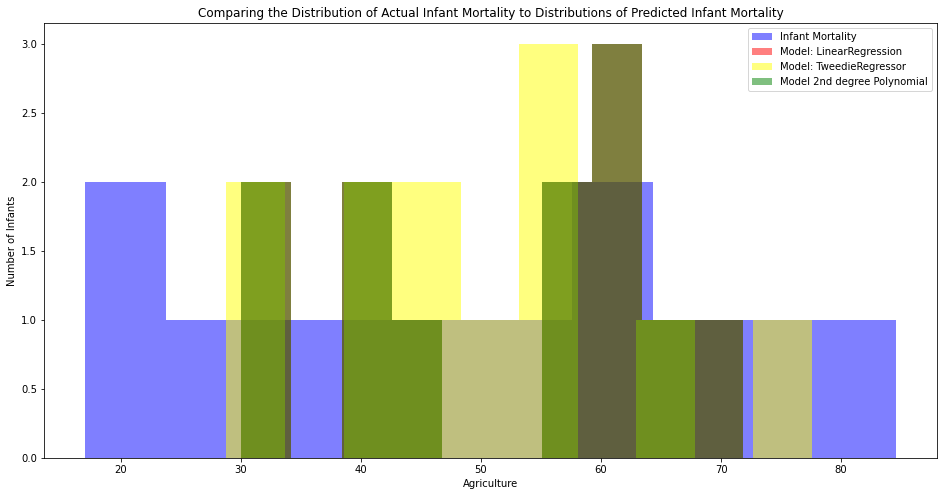

In [57]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.Agriculture, color='blue', alpha=.5, label="Infant Mortality")
plt.hist(y_validate.Agriculture_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.Agriculture_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.Agriculture_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Agriculture")
plt.ylabel("Number of Infants")
plt.title("Comparing the Distribution of Actual Infant Mortality to Distributions of Predicted Infant Mortality")
plt.legend()
plt.show()

In [58]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['Agriculture_pred_glm'] = lm.predict(X_test)

# evaluate: rmse

rmse_test = mean_squared_error(y_test.Agriculture, y_test.Agriculture_pred_glm) ** (1/2)

print("RMSE for Tweedie Regression Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Tweedie Regression Model using LinearRegression
Out-of-Sample Performance:  21.11838356760244
